In [76]:
import pandas as pd
import numpy as np

df=pd.read_csv("ambient_temperature_system_failure.csv")
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


In [77]:
failure_value = df['value'].to_list()
len(failure_value)

7267

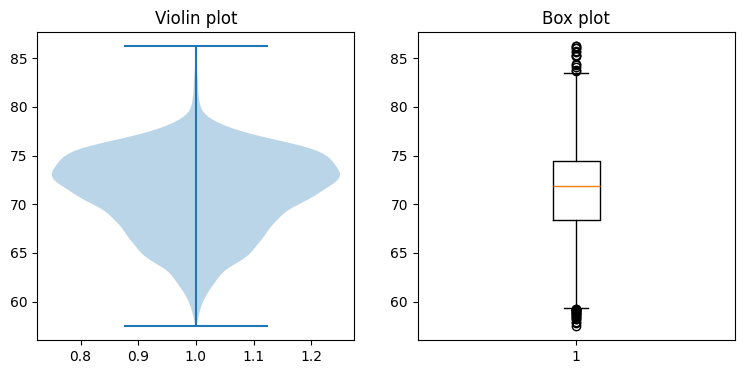

In [78]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Fixing random state for reproducibility
np.random.seed(42)

# plot violin plot
axs[0].violinplot(failure_value)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot(failure_value)
axs[1].set_title('Box plot')

plt.show()

Text(0, 0.5, 'Failure Values')

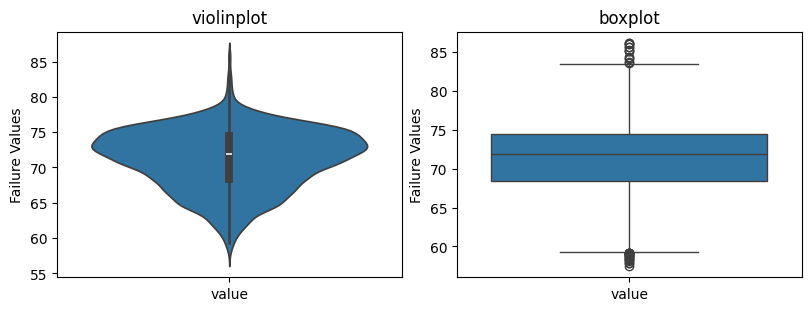

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax =plt.subplots(1,2,constrained_layout=True, figsize=(8, 3))
axesSub = sns.violinplot(data=pd.DataFrame(df['value']),ax=ax[0])
axesSub.set_title('violinplot')
axesSub.set_ylabel('Failure Values')  # 設置 y 軸標籤
axesSub = sns.boxplot(data=pd.DataFrame(df['value']), ax=ax[1])
axesSub.set_title('boxplot')
axesSub.set_ylabel('Failure Values')  # 設置 y 軸標籤

In [80]:
# 確保 timestamp 轉換為 datetime 格式並設置為索引
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

False    7245
True       22
Name: Kmeans_Abnormal, dtype: int64


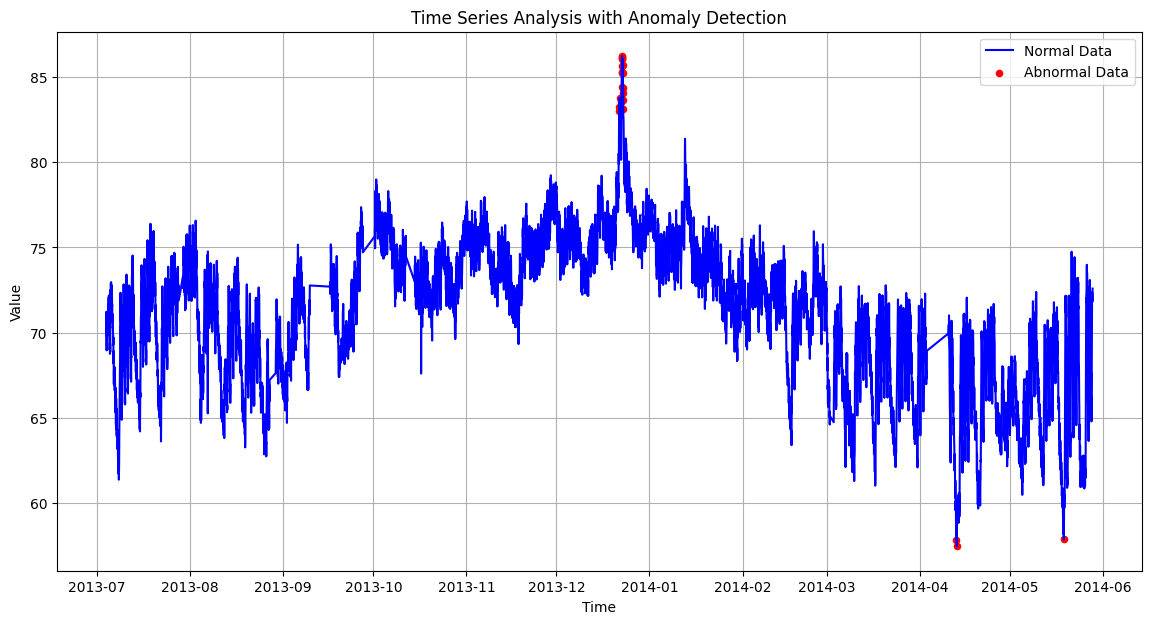

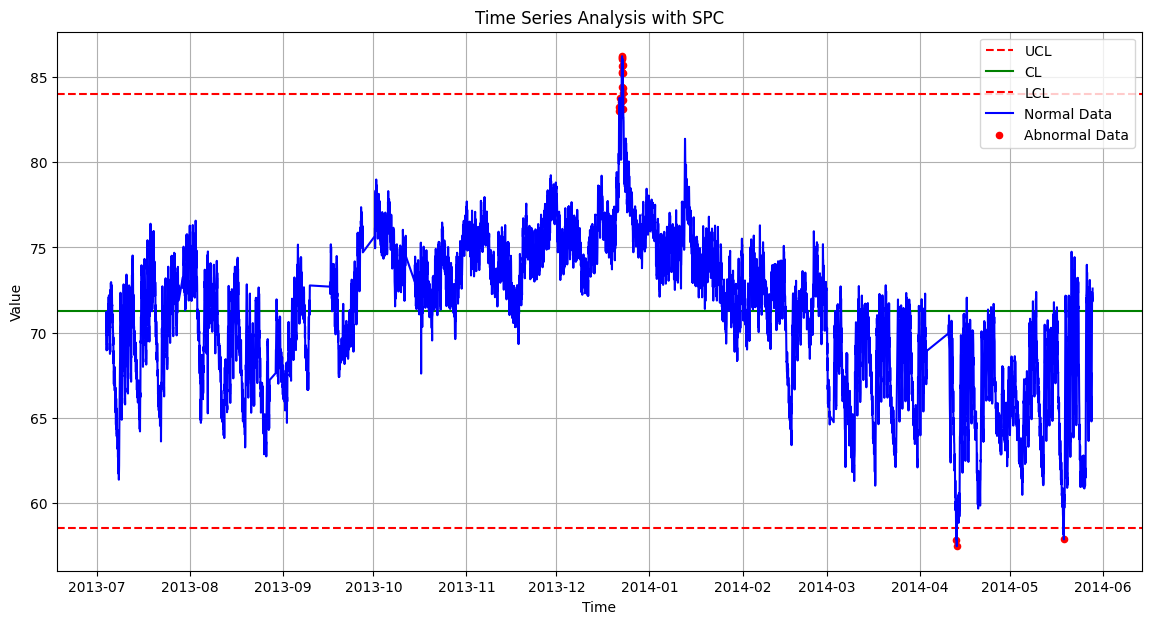

In [89]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings 

# adding entry into the specifications 
# of the warnings filter. 
warnings.filterwarnings('ignore')

X=df[['value']]

# 對數據進行標準化，使每個特徵的均值為 0，標準差為 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add labels to the dataset
df['KMeans_Cluster'] = kmeans_labels

# 計算每個數據點到其分配的聚類中心的歐幾里得距離
# kmeans.cluster_centers_ 是每個聚類的中心點（標準化數據空間中的坐標）
# 距離反映數據點與聚類中心的相似性：距離越大，越不像該聚類的典型點
# Calculate distance of each point to its assigned cluster centroid
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# 設置潛在異常的閾值
# 計算距離的第 99.7 百分位（即所有點中距離最遠的前 0.3%）
# Define a threshold (e.g., top 5% farthest from centroids)
threshold = np.percentile(distances, 99.7)  # Change this value as needed  /  = distances.quantile(0.997)

# 將距離超過閾值的數據點標記為潛在欺詐（True）
# Flag points above the threshold as potential frauds
df['Kmeans_Abnormal'] = distances > threshold

print(df['Kmeans_Abnormal'].value_counts())


# 繪製所有數據點
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['value'], label='Normal Data', color='blue')

# 突出顯示潛在的欺詐點
abnormal_points = df[df['Kmeans_Abnormal']]
plt.scatter(abnormal_points.index, abnormal_points['value'], color='red', label='Abnormal Data', s=20)  # 使用較大的點來標記

# 添加標題和圖例
plt.title('Time Series Analysis with Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# 顯示圖形
plt.grid(True) # 顯示網格
plt.show()

# 計算平均值和標準差
mean_value = df['value'].mean()
std_value = df['value'].std()

# 設置控制限
upper_control_limit = mean_value + 3 * std_value
lower_control_limit = mean_value - 3 * std_value

# 繪製時間序列及控制限
plt.figure(figsize=(14, 7))
plt.axhline(y=upper_control_limit, color='r', linestyle='--', label='UCL')
plt.axhline(y=mean_value, color='g', linestyle='-', label='CL')
plt.axhline(y=lower_control_limit, color='r', linestyle='--', label='LCL')

plt.plot(df.index, df['value'], label='Normal Data', color='blue')
# 突出顯示潛在的異常點
abnormal_points = df[df['Kmeans_Abnormal']]
plt.scatter(abnormal_points.index, abnormal_points['value'], color='red', label='Abnormal Data', s=20)

# 添加標題和圖例
plt.title('Time Series Analysis with SPC')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# 顯示圖形
plt.grid(True)
plt.show()